# Musings on manifolds
### Contents:
1. Introduction
2. Orthogonal networks
3. Monotone constraints

## Introduction
Generally, when practitioners talk about "manifold learning", they are referring to one of two things:
1. a form of dimensionality reduction which involves discovering and exploiting some low-dimensional structure of a high-dimensional input space;
2. constraining the output of a model to lie on some not-necessarily-euclidean manifold

A very simple example of #2 might be to take a scalar output of a model, clip it to lie in $[0, 2\pi)$, and treat that as if it were a point on the unit circle. Boundary conditions may be applied if desired.

When we revisit the definition of a function (in the mathematical sense), it comes in three parts:
1. a domain (the set of inputs)
2. a codomain (the set of possible outputs)
3. a rule that assigns to each input exactly one output

You can see that the two aforementioned examples of manifold learning match quite nicely onto #1 and #2 here. But what about point #3?

Usually, the map of a function is considered to be fixed. However, it is quite common in the realm of applied mathematics to fit a function to data, in which case the data remain fixed, and it is the map that varies. It is possible to constrain our search space to a certain manifold that may have properties that we would like to exploit. 

## Orthogonal networks
Consider a neural network with square hidden layers. It is possible to constrain the weight matrices for these layers to be orthogonal matrices with positive determinant. (The set of all orthogonal matrices is disconnected, since the determinant must be either 1 or -1, and hence not a manifold.) This is one way to resolve the exploding/vanishing gradient problem, as the norm of an orthogonal matrix is 1. Note that this is only valid for $m\times n$ matrices where $m \geq n$, otherwise the matrix cannot be orthogonal.

### Simple example:

In [1]:
import numpy as np

from matplotlib import pyplot as plt

n_in = 3
n_out = 3
n_hidden = 16

np.random.seed(0)

def orthogonal_matrix(n):
    return np.linalg.qr(np.random.rand(n, n))[0]

W_ortho = [np.linalg.svd(np.random.rand(n_hidden, n_in))[0][:, :n_in], *[orthogonal_matrix(n_hidden) for _ in range(100)]]

# Glorot initialization
d = np.sqrt(6 / (n_in + n_hidden))
W_standard = [np.random.rand(n_hidden, n_in) * 2 * d - d, *[np.random.rand(n_hidden, n_hidden) * 2 * d - d for _ in range(100)]]

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def network(x, W, norms):
    z = x
    for w in W[:-1]:
        z = sigmoid(w @ z)
        norms.append(np.linalg.norm(z, axis=0))
    z = W[-1] @ z
    norms.append(np.linalg.norm(z, axis=0))
    return z

x = np.random.randn(n_in, 1000)

norms = []
y = network(x, W_standard, norms)
ortho_norms = []
y = network(x, W_ortho, ortho_norms)

Text(0.5, 1.0, 'Ratio of norm of network output at each layer to norm of input')

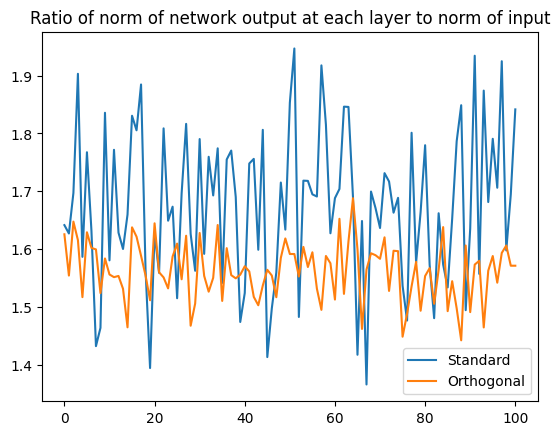

In [2]:
plt.plot(np.mean(np.array(norms) / np.linalg.norm(x, axis=0), axis=1))
plt.plot(np.mean(np.array(ortho_norms) / np.linalg.norm(x, axis=0), axis=1))
plt.legend(["Standard", "Orthogonal"])
plt.title("Ratio of norm of network output at each layer to norm of input")

We see that the ratio of the output norms to the input norms stays closer to 1.0 for the orthogonal network. Deviation from 1 is caused by the nonlinearity of the activation function.

## Monotone constraints
When modeling a physical phenomenon, and also for other reasons such as explainability, compliance with business logic, or inductive bias, it is often desirous to enforce that a model's output vary monotonically w.r.t. one or many of its inputs. This is facilitated by certain ML libraries such as XGBoost and LightGBM, which provide such functionality out of the box. It is also possible to do this with deep neural networks, although it requires a bit of derivation.

Consider a simple $n$-layer perceptron $\mathbb{R} \to \mathbb{R}$ with non-decreasing activation functions $\sigma_i$ between each layer and no layer bias. The partial derivative of an output w.r.t. the input is given by applying the chain rule:

$$\frac{\partial y}{\partial x} = W_n \sigma_n\prime(h_{n-1}) \odot W_{n-1} \sigma_{n-1}\prime(h_{n-2}) \odot \cdots W_1$$

where $\odot$ denotes elementwise multiplication and $h_i$ is the output of hidden layer $i$. Note that in the multidimensional case, we simply take the $i$th row of $W_n$ and the $j$th column of $W_1$ to compute $\frac{\partial y_i}{\partial x_j}$.

We want to constrain this derivative to be $\geq 0$. Because $\sigma_i$ are non-decreasing, $\sigma_i\prime \geq 0$ and we can ignore their contribution to the gradient, simplifying to:

$$\widetilde\frac{\partial y}{\partial x} = W_n W_{n-1} \cdots W_1$$

In order for this to be non-negative, it suffices to constrain each factor to be non-negative. (In truth, we need an even number of odd entries, but choosing zero eliminates some complexity.) For it to be non-positive, simply enforce that one be non-positive.

### Simple example:

In [3]:
import numpy as np

from matplotlib import pyplot as plt

n_in = 3
n_out = 3
n_hidden = 16

np.random.seed(0)
W1 = np.random.randn(n_hidden, n_in)
W1[:, 0] = np.abs(W1[:, 0])
Wn = np.random.randn(n_out, n_hidden)
Wn[0, :] = np.abs(Wn[0, :])

W = [W1, *[np.random.rand(n_hidden, n_hidden) for _ in range(3)], Wn]

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def network(x):
    for w in W[:-1]:
        x = sigmoid(w @ x)
    return Wn @ x

Text(0.5, 1.0, 'Monotone network output')

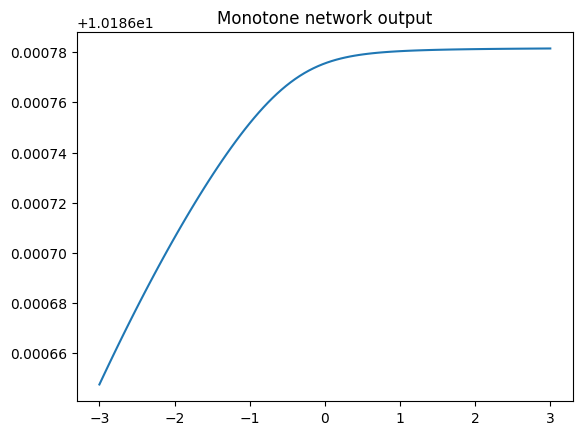

In [4]:
x = np.zeros((n_in, 100))
x[0, :] = np.linspace(-3, 3, 100)

y = network(x)
plt.plot(x[0, :], y[0])
plt.title("Monotone network output")

It is also possible to construct networks with a desired set of curvature constraints, although this derivation is more tedious.

Trainable example: TODO